# E-commerce Business Transaction Data Analysis
Data source: https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business

### Step 1: Setting up the environment

In [274]:
import pandas as pd
import matplotlib.pyplot as plt

### Step 2: Loading and Inspecting the Data

In [275]:
file = "/Users/ramilojr.subiate/Documents/FILES/etl-to-dashboard/kaggle_data/sales_transaction.csv"
df = pd.read_csv(file)

In [276]:
df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


In [277]:
df.shape

(536350, 8)

In [278]:
df.columns

Index(['TransactionNo', 'Date', 'ProductNo', 'ProductName', 'Price',
       'Quantity', 'CustomerNo', 'Country'],
      dtype='object')

In [279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


### Step 3: Cleaning and Preparing the Data

3.1 Renaming columns for clarity

In [280]:
df.rename(columns={
    "TransactionNo": "transaction_num",
    "Date": "date",
    "ProductNo": "product_num",
    "ProductName": "product_name",
    "Price": "price",
    "Quantity": "quantity",
    "CustomerNo": "customer_num",
    "Country": "country"
}, inplace=True)

df.columns

Index(['transaction_num', 'date', 'product_num', 'product_name', 'price',
       'quantity', 'customer_num', 'country'],
      dtype='object')

3.2 Dropping duplicates

In [281]:
df.duplicated().sum()

np.int64(5200)

In [282]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

3.3 Fixing Data types

In [283]:
df["date"] = pd.to_datetime(df["date"])
df["customer_num"] = df["customer_num"].astype("Int64")

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531150 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   transaction_num  531150 non-null  object        
 1   date             531150 non-null  datetime64[ns]
 2   product_num      531150 non-null  object        
 3   product_name     531150 non-null  object        
 4   price            531150 non-null  float64       
 5   quantity         531150 non-null  int64         
 6   customer_num     531095 non-null  Int64         
 7   country          531150 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 37.0+ MB


3.4 Handling Missing Values

In [285]:
df.isna().sum()

transaction_num     0
date                0
product_num         0
product_name        0
price               0
quantity            0
customer_num       55
country             0
dtype: int64

3.5 Dropping cancelled orders

New DataFrame has been created called df_cleaned which removed both duplicated rows (original purchase and cancelled purchase)

In [286]:
df["no_C_transaction_num"] = df["transaction_num"].str.replace("C", "", regex=False)
df["abs_quantity"] = df["quantity"].abs()

df["product_name"] = df["product_name"].str.lower().str.strip()
df["price"] = df["price"].astype(float).round(2)

# Creating new DataFrame (df_cleaned), removing all cancelled transaction (both the (+)quantity and (-)quantity)
columns_to_identify_cancel_pairs = ["product_name", "price", "customer_num", "abs_quantity", "no_C_transaction_num"]
dup_mask = df.duplicated(subset=columns_to_identify_cancel_pairs, keep=False)
df_cleaned = df[~dup_mask].copy()

df_cleaned.drop(columns=["abs_quantity", "no_C_transaction_num"], inplace=True)

print(df_cleaned.shape)
df.shape



(531150, 8)


(531150, 10)

Transactions with a transaction_num that starts with "C" and have negative quantity values do not always have a corresponding positive-quantity transaction with the same ID.

Therefore, all records with negative quantity values will be dropped from the dataset, assuming they represent cancelled or returned orders.

These cleaned records will be stored in the df_cleaned DataFrame for analysis.

In [287]:
df_cleaned = df[df["quantity"] > 0].copy()
df_cleaned.describe()


,date,price,quantity,customer_num,abs_quantity
count,522602,522602.000000,522602.000000,522601.0,522602.000000
mean,2019-07-04 03:24:38.308923392,12.637155,10.667487,15226.311767,10.667487
min,2018-12-01 00:00:00,5.130000,1.000000,12004.0,1.000000
25%,2019-03-28 00:00:00,10.990000,1.000000,13804.0,1.000000
50%,2019-07-20 00:00:00,11.940000,4.000000,15152.0,4.000000
75%,2019-10-19 00:00:00,14.090000,12.000000,16729.0,12.000000
max,2019-12-09 00:00:00,660.620000,80995.000000,18287.0,80995.000000
std,NaN,7.965967,157.542269,1716.555479,157.542269


In [288]:
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522602 entries, 0 to 522601
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   transaction_num       522602 non-null  object        
 1   date                  522602 non-null  datetime64[ns]
 2   product_num           522602 non-null  object        
 3   product_name          522602 non-null  object        
 4   price                 522602 non-null  float64       
 5   quantity              522602 non-null  int64         
 6   customer_num          522601 non-null  Int64         
 7   country               522602 non-null  object        
 8   no_C_transaction_num  522602 non-null  object        
 9   abs_quantity          522602 non-null  int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 40.4+ MB


### Step 4: Understanding the variables

"transaction_num": six-digit unique number that defines each transaction

"date": date when each transaction was generated

"product_num": five or six-digit unique character used to identify a specific product

"product_name": product/item name

"price": price of each product per unit in pound sterling

"quantity": the quantity of each product per transaction

"customer_num": five-digit unique number that defines each customer

"country": name of the country where the customer resides


### Step 5: Univariate Analysis

5.1 Distribution of Prices

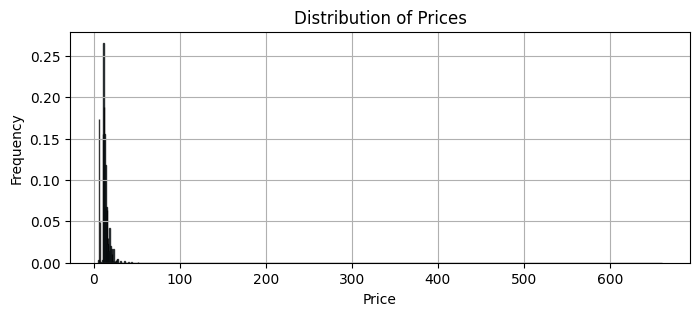

In [289]:
data_price = df_cleaned["price"]
plt.figure(figsize=(8,3))
plt.hist(data_price, bins=1000, color="skyblue", edgecolor="black", alpha=0.80, density=True)
plt.title("Distribution of Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

5.2 Boxplot of Price

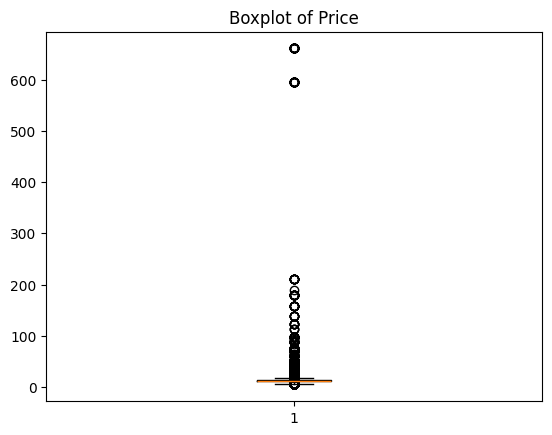

In [290]:
plt.boxplot(data_price)
plt.title("Boxplot of Price")
plt.show()

5.3 Distribution of Quantity

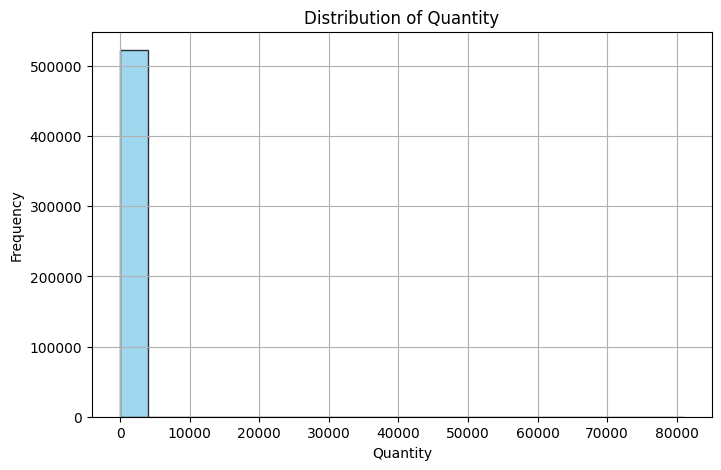

In [291]:
data_quantity = df_cleaned["quantity"]
plt.figure(figsize=(8, 5))
plt.hist(data_quantity, bins=20, color="skyblue", edgecolor="black", alpha=0.8)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.grid("True")
plt.show()

5.4 Boxplot of Quantity

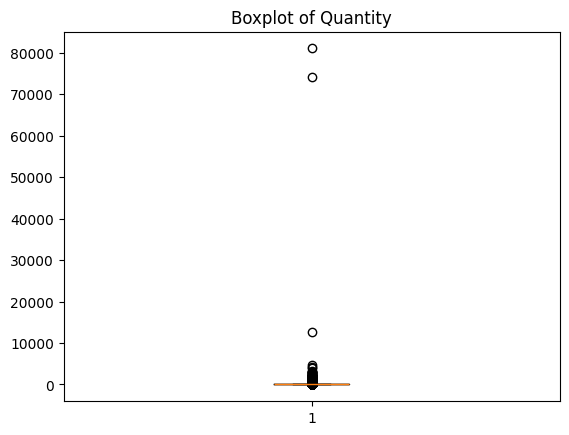

In [292]:
plt.boxplot(data_quantity)
plt.title("Boxplot of Quantity")
plt.show()

5.5 Number of unique values per categorical variables

In [ ]:
print(f"Number of unique 'product_num': {df_cleaned["product_num"].nunique()}")
print(f"Number of unique 'product_name': {df_cleaned["product_name"].nunique()}")
print(f"Number of unique 'customer_num': {df_cleaned["customer_num"].nunique()}")
print(f"Number of unique 'country': {df_cleaned["country"].nunique()}")


Number of unique 'product_num': 3768
Number of unique 'product_name': 3768
Number of unique 'customer_num': 4738
Number of unique 'country': 38


5.6 Top 10 Country by Frequency

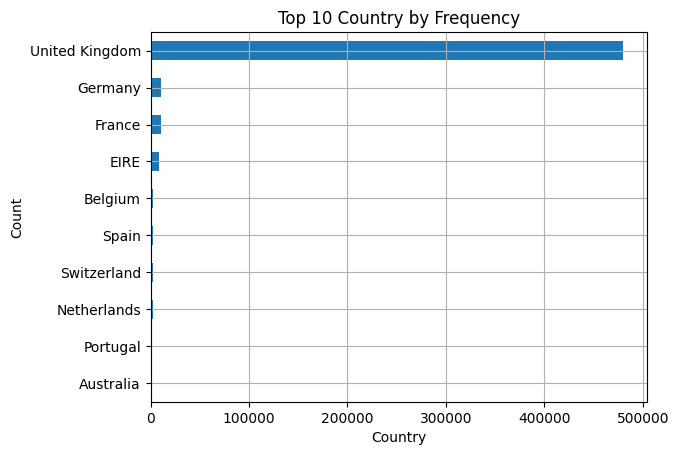

In [319]:
data_country = df_cleaned["country"].value_counts().sort_values(ascending=True).tail(10)
data_country.plot(kind="barh")
plt.title("Top 10 Country by Frequency")
plt.xlabel('Country')
plt.ylabel('Count')
plt.grid(True)
plt.show()


In [316]:
df_cleaned.describe()



,date,price,quantity,customer_num
count,531150,531150.000000,531150.000000,531095.0
mean,2019-07-04 00:23:47.393391616,12.669787,9.988540,15222.612241
min,2018-12-01 00:00:00,5.130000,-80995.000000,12004.0
25%,2019-03-28 00:00:00,10.990000,1.000000,13798.0
50%,2019-07-20 00:00:00,11.940000,3.000000,15146.0
75%,2019-10-19 00:00:00,14.090000,10.000000,16727.0
max,2019-12-09 00:00:00,660.620000,80995.000000,18287.0
std,NaN,8.525988,217.700768,1716.633588


5.7 Top 10 product name

In [315]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531150 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   transaction_num  531150 non-null  object        
 1   date             531150 non-null  datetime64[ns]
 2   product_num      531150 non-null  object        
 3   product_name     531150 non-null  object        
 4   price            531150 non-null  float64       
 5   quantity         531150 non-null  int64         
 6   customer_num     531095 non-null  Int64         
 7   country          531150 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 37.0+ MB
